In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from biosppy.signals import ecg
from scipy.signal import find_peaks

In [30]:
# Path to folder containing .hea and .mat files
data_folder = "Training_PTB"

# List to store extracted data
data_list = []

# Iterate through each file in the data folder
for file in tqdm(os.listdir(data_folder)):
    if file.endswith(".hea"):
        record_name = file.replace(".hea", "")  # Remove extension
        hea_file = os.path.join(data_folder, f"{record_name}.hea")
        mat_file = os.path.join(data_folder, f"{record_name}.mat")

        # Step 2: Load ECG Signals from .mat File
        mat_data = scipy.io.loadmat(mat_file)
        signals = mat_data["val"]  # Shape: (12, n_samples)

        # Step 4: Convert List to DataFrame
        df_raw = pd.DataFrame(signals).transpose()
        df_raw['record_name'] = record_name  # Add record name to the DataFrame

        data_list.append(df_raw)

# Concatenate all DataFrames into one
df_raw = pd.concat(data_list, ignore_index=True)

# Save the combined dataset to CSV
df_raw.to_csv("ecg_raw_dataset.csv", index=False)

print("Combined dataset created successfully! 🎉")
df_raw.head()

100%|██████████| 1032/1032 [00:11<00:00, 86.12it/s]


Combined dataset created successfully! 🎉


,0,1,2,3,4,5,6,7,8,9,10,11,record_name
0,-245,-229,16,237,-130,-107,-44,-121,-56,106,197,195,S0001
1,-243,-234,9,238,-126,-113,-42,-118,-51,110,202,198,S0001
2,-242,-235,7,238,-124,-114,-44,-118,-54,110,201,197,S0001
3,-241,-229,12,235,-126,-109,-45,-118,-52,112,201,197,S0001
4,-232,-227,5,230,-118,-112,-46,-117,-50,112,200,199,S0001


In [2]:
ecg_raw_dataset = pd.read_csv("ecg_raw_dataset.csv")
ecg_raw_dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,record_name
0,-245,-229,16,237,-130,-107,-44,-121,-56,106,197,195,S0001
1,-243,-234,9,238,-126,-113,-42,-118,-51,110,202,198,S0001
2,-242,-235,7,238,-124,-114,-44,-118,-54,110,201,197,S0001
3,-241,-229,12,235,-126,-109,-45,-118,-52,112,201,197,S0001
4,-232,-227,5,230,-118,-112,-46,-117,-50,112,200,199,S0001


In [ ]:
# 📂 Path to folder containing .hea and .mat files
data_folder = "Training_PTB"

# 📝 List to store extracted data
data_list = []

# 🔄 Iterate through each .mat & .hea file
for file in tqdm(os.listdir(data_folder)):
    if file.endswith(".hea"):
        record_name = file.replace(".hea", "")  # Remove extension
        mat_file = os.path.join(data_folder, f"{record_name}.mat")
        hea_file = os.path.join(data_folder, f"{record_name}.hea")

        # ✅ Step 1: Extract Metadata from .hea File
        with open(hea_file, "r") as f:
            lines = f.readlines()

        num_leads = int(lines[0].split()[1])
        sampling_rate = int(lines[0].split()[2])
        num_samples = int(lines[0].split()[3])
        age, sex, diagnosis = None, None, None

        for line in lines:
            if line.startswith("#Age:"):
                age_str = line.split(":")[1].strip()
                age = int(age_str) if age_str.isdigit() else np.nan
            elif line.startswith("#Sex:"):
                sex = line.split(":")[1].strip()  # Extract sex
            elif line.startswith("#Dx:"):
                diagnosis = line.split(":")[1].strip()  # Extract diagnosis

        # ✅ Step 2: Load ECG Signals from .mat File
        mat_data = scipy.io.loadmat(mat_file)
        signals = mat_data["val"]  # Shape: (12, n_samples)

        # ✅ Step 3: Extract Statistical Features for Each Lead
        features = {}
        for i, lead_name in enumerate(["I", "II", "III"]):
            lead_signal = signals[i]

            features[f"{lead_name}_mean"] = np.mean(lead_signal)

        # ✅ Step 4: Extract Additional ECG Features (Heart Rate, R-peaks)
        processed_ecg = ecg.ecg(signal=signals[1], sampling_rate=1000, show=False)  # Using Lead II
        heart_rate = np.mean(processed_ecg["heart_rate"])
        rr_intervals = np.diff(processed_ecg["rpeaks"]) / 1000  # Convert to seconds
        rr_std = np.std(rr_intervals) if len(rr_intervals) > 0 else np.nan

        # ✅ Step 5: Store in List
        data_list.append({
            "record_name": record_name,
            "age": age,
            "sex": sex,
            "diagnosis": diagnosis,
            "num_leads": num_leads,
            "sampling_rate": sampling_rate,
            "num_samples": num_samples,
            "heart_rate": heart_rate,
            "rr_std": rr_std,
            **features
        })

# ✅ Step 6: Convert List to DataFrame
df = pd.DataFrame(data_list)

# ✅ Step 7: Save to CSV
df.to_csv("patient_record_dataset.csv", index=False)

print("Dataset created successfully! 🎉")
df.head()

 74%|███████▍  | 767/1032 [01:39<00:31,  8.49it/s]c:\Users\adria\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\adria\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1032/1032 [02:14<00:00,  7.65it/s]

Dataset created successfully! 🎉


,record_name,age,sex,diagnosis,num_leads,sampling_rate,num_samples,heart_rate,rr_std,I_mean,II_mean,III_mean
0,S0001,81.0,female,164865005,12,1000,38400,81.812332,0.009155,-0.097135,-0.209167,0.119948
1,S0002,81.0,female,164865005,12,1000,115200,86.319912,0.020189,0.270234,-0.278082,0.026146
2,S0003,81.0,female,164865005,12,1000,115200,79.867143,0.010508,-0.215122,0.146128,-0.140503
3,S0004,58.0,female,164865005,12,1000,115200,78.931881,0.021077,0.177352,-0.111250,0.268924
4,S0005,63.0,male,164865005,12,1000,115200,72.340308,0.022680,0.162240,-0.098325,0.384844


In [3]:
patient_record_dataset = pd.read_csv("patient_record_dataset.csv")
patient_record_dataset.head()

,record_name,age,sex,diagnosis,num_leads,sampling_rate,num_samples,heart_rate,rr_std,I_mean,II_mean,III_mean
0,S0001,81.0,female,164865005,12,1000,38400,81.812332,0.009155,-0.097135,-0.209167,0.119948
1,S0002,81.0,female,164865005,12,1000,115200,86.319912,0.020189,0.270234,-0.278082,0.026146
2,S0003,81.0,female,164865005,12,1000,115200,79.867143,0.010508,-0.215122,0.146128,-0.140503
3,S0004,58.0,female,164865005,12,1000,115200,78.931881,0.021077,0.177352,-0.111250,0.268924
4,S0005,63.0,male,164865005,12,1000,115200,72.340308,0.022680,0.162240,-0.098325,0.384844


In [4]:
print(patient_record_dataset.head()[patient_record_dataset.head().isnull().any(axis=1)])

Empty DataFrame
Columns: [record_name, age, sex, diagnosis, num_leads, sampling_rate, num_samples, heart_rate, rr_std, I_mean, II_mean, III_mean]
Index: []


In [6]:
unique_sampling_rate = patient_record_dataset["num_samples"].unique()
print(unique_sampling_rate)

[ 38400 115200 115174  32000  87910  96588  76800 120012  91987 118184
  97000]


ECG signal shape: (12, 38400)
Number of samples: 38400, Sampling rate: 1000
Extracted 3 lead names: ['I', 'II', 'III']
Samples to plot: 10000


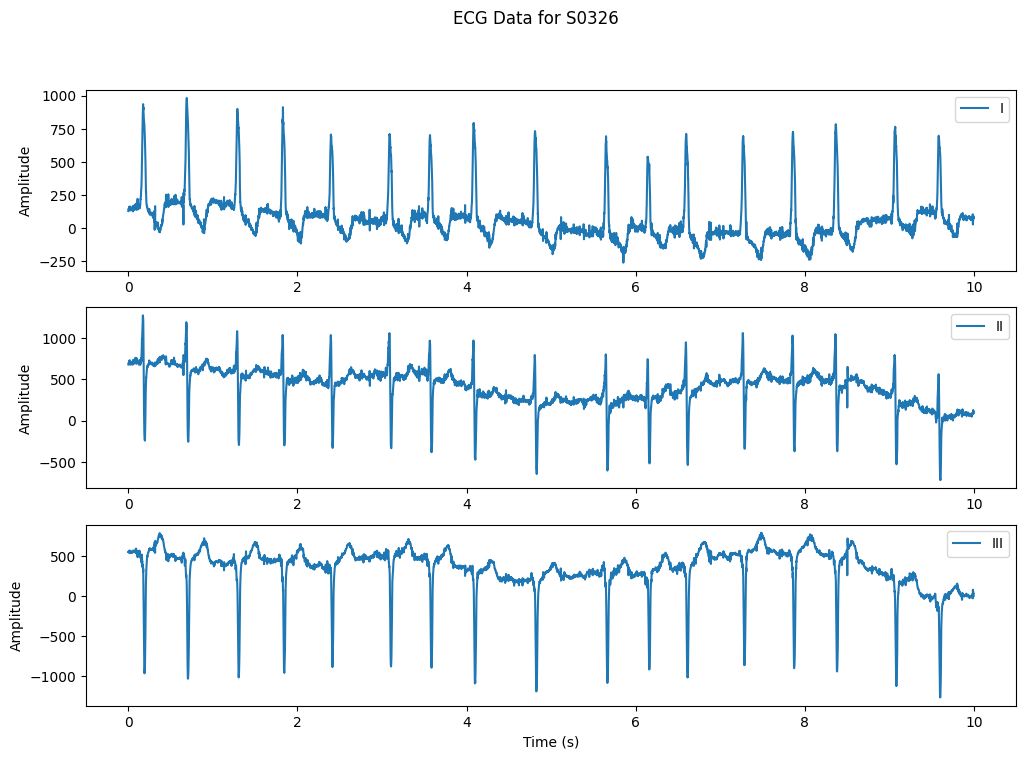

In [11]:
def load_ecg_data(record_name, duration_seconds=10):
    """ Load and visualize ECG data from a given record (e.g., 'S0001') """

    # Construct file paths
    folder_path = "Training_PTB"
    mat_file = os.path.join(folder_path, f"{record_name}.mat")
    hea_file = os.path.join(folder_path, f"{record_name}.hea")

    # Load .mat file
    mat_data = scipy.io.loadmat(mat_file)
    
    # Find the key containing ECG data
    signal_key = [key for key in mat_data.keys() if not key.startswith("__")]
    if not signal_key:
        print(f"No valid signal found in {mat_file}")
        return
    
    ecg_signals = mat_data[signal_key[0]]  # Extract signal data
    print(f"ECG signal shape: {ecg_signals.shape}") 
    num_leads = 3

    # Load .hea file and extract metadata
    with open(hea_file, "r") as f:
        header_lines = f.readlines()
    
    num_samples = int(header_lines[0].split()[3])
    sampling_rate = int(header_lines[0].split()[2])  # Extract sampling rate
    print(f"Number of samples: {num_samples}, Sampling rate: {sampling_rate}")

    # Extract lead names dynamically
    lead_names = [line.split()[-1] for line in header_lines[1:1 + num_leads]]  # Adjusted to match actual leads
    print(f"Extracted {len(lead_names)} lead names: {lead_names}")

    # Fix mismatch if needed
    if len(lead_names) != num_leads:
        print("Warning: Lead names count does not match ECG data columns. Using default names.")
        lead_names = [f"Lead {i+1}" for i in range(num_leads)]

    num_samples_to_plot = duration_seconds * sampling_rate
    num_samples_to_plot = min(num_samples_to_plot, num_samples)
    # num_samples_to_plot = min(num_samples_to_plot, ecg_signals.shape[1])

    print(f"Samples to plot: {num_samples_to_plot}")

    # Plot ECG signals
    plt.figure(figsize=(12, 8))
    for i in range(num_leads):
        plt.subplot(num_leads, 1, i + 1)
        plt.plot(np.arange(num_samples_to_plot) / sampling_rate, ecg_signals[i, :num_samples_to_plot], label=lead_names[i])
        plt.ylabel("Amplitude")
        plt.legend(loc="upper right")

    plt.xlabel("Time (s)")
    plt.suptitle(f"ECG Data for {record_name}")
    plt.show()

# Example Usage
record_name = "S0326"  # Change this to the file you want to visualize
# record_name = "S0001"
load_ecg_data(record_name, duration_seconds=10)

In [41]:
unique_diagnoses = patient_record_dataset['diagnosis'].unique()
print(unique_diagnoses)

['164865005' '164896001,164865005' '164895002,164865005' '426783006'
 '368009' '204384007,698247007' '698247007' '53741008,164889003,698247007'
 '84114007' '53741008,84114007' '53741008' '84114007,266249003'
 '266249003' '53741008,164865005' '164895002,53741008,164865005'
 '164865005,74390002' '314208002,53741008,164865005' '164889003,698247007'
 '164890007,698247007' '6374002' '164889003,84114007,698247007'
 '164896001,53741008,164865005' '282825002,164865005' '164889003'
 '164865005,6374002' '53741008,266249003' '53741008,6374002'
 '53741008,698247007' '6374002,53741008,164889003' '368009,427084000'
 '164895002' '698247007,74390002'
 '164895002,164896001,164865005,164889003']


In [4]:
specific_diagnosis = "53741008"

filtered_patients = df[df['diagnosis'].str.contains(specific_diagnosis, regex=False)]
filtered_patients

,record_name,age,sex,diagnosis,num_leads,sampling_rate,num_samples,heart_rate,rr_std,I_mean,II_mean,III_mean
325,S0326,65.0,female,"53741008,164889003,698247007",12,1000,38400,104.980745,0.105719,0.052057,-0.044870,-0.141979
326,S0327,65.0,female,"53741008,164889003,698247007",12,1000,76800,108.217341,0.095763,-0.059062,0.086523,0.099245
332,S0333,70.0,male,"53741008,84114007",12,1000,38400,87.562143,0.006852,0.261016,0.140182,-0.111536
337,S0340,62.0,male,53741008,12,1000,38400,74.509748,0.161363,-0.210729,-0.213672,-0.097318
342,S0345,75.0,male,53741008,12,1000,38400,58.422540,0.143973,0.187526,-0.151667,0.207943
347,S0351,84.0,male,"53741008,164865005",12,1000,38400,89.665230,0.008690,0.249401,-0.086120,0.171172
350,S0354,46.0,male,"164895002,53741008,164865005",12,1000,115200,79.188293,0.012750,-0.185556,0.239922,-0.233941
355,S0362,53.0,male,"314208002,53741008,164865005",12,1000,38400,89.776364,0.145687,-0.145052,-0.106484,0.045339
356,S0363,53.0,male,"314208002,53741008,164865005",12,1000,38400,91.212595,0.071325,0.011797,-0.092266,-0.099375
364,S0372,64.0,male,"53741008,164865005",12,1000,115200,72.926912,0.012179,0.179115,-0.368021,-0.270668


In [5]:
rows_with_nulls = filtered_patients[filtered_patients.isnull().any(axis=1)]

result = rows_with_nulls[['record_name']].copy()
result['NaN_columns'] = rows_with_nulls.apply(lambda row: row.index[row.isnull()].tolist(), axis=1)

print(result)

Empty DataFrame
Columns: [record_name, NaN_columns]
Index: []


In [6]:
filtered_patients['record_name'].values

array(['S0326', 'S0327', 'S0333', 'S0340', 'S0345', 'S0351', 'S0354',
       'S0362', 'S0363', 'S0372', 'S0373', 'S0375', 'S0410', 'S0416',
       'S0445', 'S0448', 'S0451', 'S0452', 'S0453', 'S0461', 'S0462'],
      dtype=object)

In [18]:
# List of specific file names to process (without extensions)
specific_files = ['S0326', 'S0327', 'S0333', 'S0340', 'S0345', 'S0351', 'S0354',
                  'S0362', 'S0363', 'S0372', 'S0373', 'S0375', 'S0410', 'S0416',
                  'S0445', 'S0448', 'S0451', 'S0452', 'S0453', 'S0461', 'S0462']

# Path to folder containing .hea and .mat files
data_folder = "Training_PTB"

# List to store extracted data
data_list = []

# Iterate through each specified file
for record_name in tqdm(specific_files):
    hea_file = os.path.join(data_folder, f"{record_name}.hea")
    mat_file = os.path.join(data_folder, f"{record_name}.mat")

    # Step 2: Load ECG Signals from .mat File
    mat_data = scipy.io.loadmat(mat_file)
    signals = mat_data["val"]  # Shape: (12, n_samples)

    # Step 4: Convert List to DataFrame
    df_raw = pd.DataFrame(signals).transpose()
    df_raw['record_name'] = record_name  # Add record name to the DataFrame

    data_list.append(df_raw)

# Concatenate all DataFrames into one
df_combined = pd.concat(data_list, ignore_index=True)

# Save the combined dataset to CSV
df_combined.to_csv("ecg_combined_dataset.csv", index=False)

print("Combined dataset created successfully! 🎉")
df_combined.head()

100%|██████████| 21/21 [00:00<00:00, 65.15it/s]


Combined dataset created successfully! 🎉


,0,1,2,3,4,5,6,7,8,9,10,11,record_name
0,127,678,551,-402,-212,615,974,759,751,872,858,872,S0326
1,131,684,553,-408,-211,619,985,768,753,875,859,873,S0326
2,139,689,550,-414,-206,620,991,771,755,874,861,873,S0326
3,138,693,554,-415,-208,624,985,769,755,877,865,875,S0326
4,144,701,557,-422,-206,629,982,767,756,878,867,876,S0326


In [18]:
df_combined = pd.read_csv("ecg_combined_dataset.csv")
df_combined.columns = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6", "record_name"]

missing_values = df_combined.isnull().sum()

df_combined.head(), missing_values

(     I   II  III  aVR  aVL  aVF   V1   V2   V3   V4   V5   V6 record_name
 0  127  678  551 -402 -212  615  974  759  751  872  858  872       S0326
 1  131  684  553 -408 -211  619  985  768  753  875  859  873       S0326
 2  139  689  550 -414 -206  620  991  771  755  874  861  873       S0326
 3  138  693  554 -415 -208  624  985  769  755  877  865  875       S0326
 4  144  701  557 -422 -206  629  982  767  756  878  867  876       S0326,
 I              0
 II             0
 III            0
 aVR            0
 aVL            0
 aVF            0
 V1             0
 V2             0
 V3             0
 V4             0
 V5             0
 V6             0
 record_name    0
 dtype: int64)

<Figure size 1200x600 with 0 Axes>

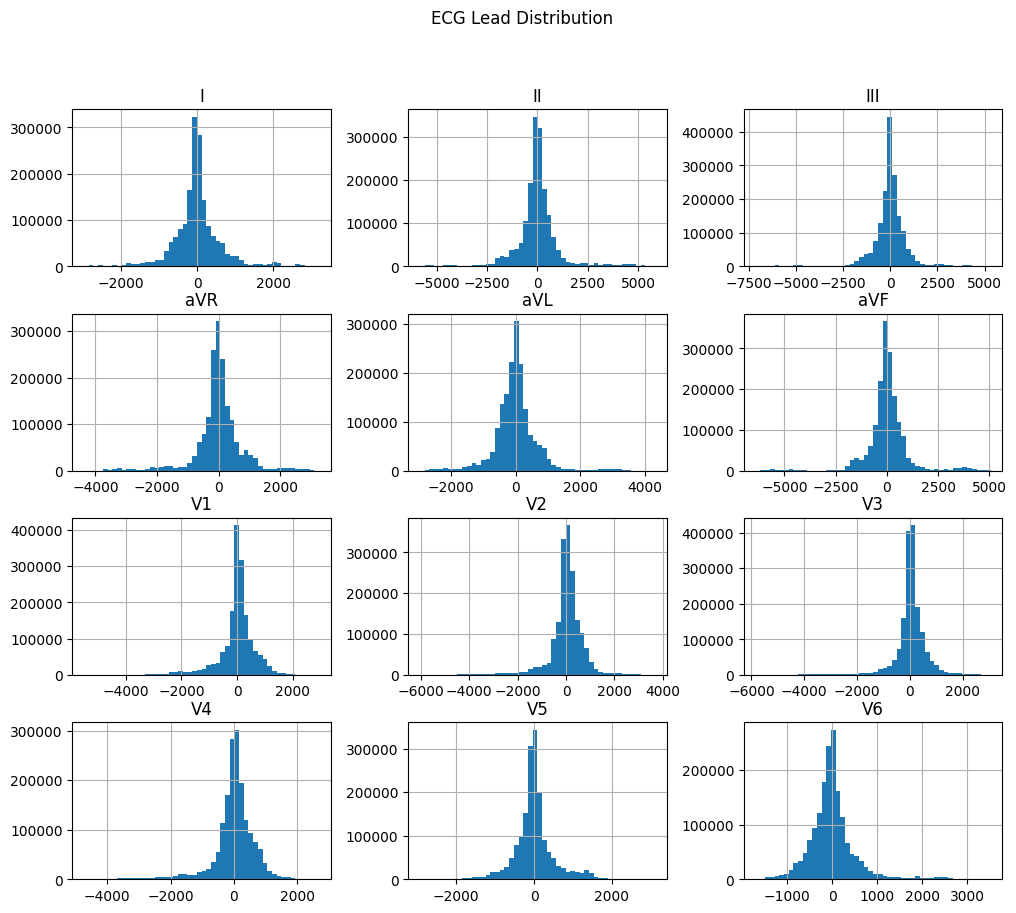

In [21]:
plt.figure(figsize=(12, 6))
df_combined.iloc[:, :-1].hist(bins=50, figsize=(12, 10))
plt.suptitle("ECG Lead Distribution")
plt.show()

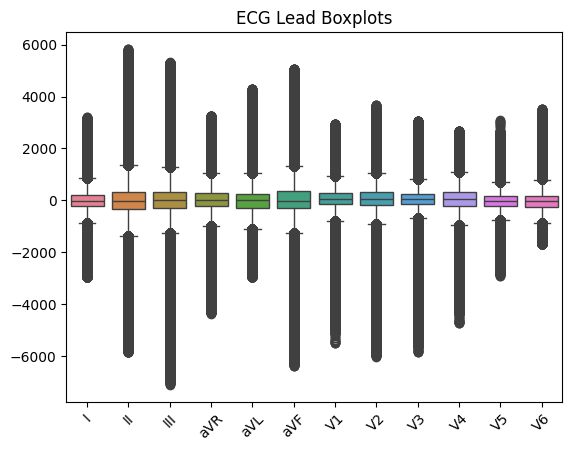

In [22]:
plt.Figure(figsize=(12, 6))
sns.boxplot(data=df_combined.iloc[:, :-1])
plt.title("ECG Lead Boxplots")
plt.xticks(rotation=45)
plt.show()

In [26]:
def compute_qrs_duration(ecg_lead):
    peaks, _ = find_peaks(ecg_lead, height=np.mean(ecg_lead))

    if len(peaks) > 1:
        return np.mean(np.diff(peaks))
    return np.nan

df_combined["QRS_duration"] = df_combined['II'].rolling(window=50).apply(compute_qrs_duration, raw=True)

df_combined['ST_elevation'] = df_combined['V3'] - df_combined['V1']

df_combined.head()

,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6,record_name,QRS_duration,ST_elevation
0,127,678,551,-402,-212,615,974,759,751,872,858,872,S0326,NaN,-223
1,131,684,553,-408,-211,619,985,768,753,875,859,873,S0326,NaN,-232
2,139,689,550,-414,-206,620,991,771,755,874,861,873,S0326,NaN,-236
3,138,693,554,-415,-208,624,985,769,755,877,865,875,S0326,NaN,-230
4,144,701,557,-422,-206,629,982,767,756,878,867,876,S0326,NaN,-226


In [27]:
df_combined

,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6,record_name,QRS_duration,ST_elevation
0,127,678,551,-402,-212,615,974,759,751,872,858,872,S0326,NaN,-223
1,131,684,553,-408,-211,619,985,768,753,875,859,873,S0326,NaN,-232
2,139,689,550,-414,-206,620,991,771,755,874,861,873,S0326,NaN,-236
3,138,693,554,-415,-208,624,985,769,755,877,865,875,S0326,NaN,-230
4,144,701,557,-422,-206,629,982,767,756,878,867,876,S0326,NaN,-226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723279,1171,248,-923,-710,1047,-338,-500,-535,87,205,27,165,S0462,7.40,587
1723280,1167,246,-921,-707,1044,-338,-503,-537,87,207,28,164,S0462,7.40,590
1723281,1168,246,-922,-707,1045,-338,-511,-539,85,205,25,157,S0462,7.40,596
1723282,1169,246,-923,-707,1046,-339,-512,-539,84,205,28,158,S0462,8.25,596


In [28]:
for lead in ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]:
    df_combined[f"{lead}_norm"] = (df_combined[lead] - df_combined[lead].mean()) / df_combined[lead].std()

df_combined = df_combined.drop(columns=["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"])

df_combined.to_csv("processed_ecg_data.csv", index=False)

In [29]:
df_combined = pd.read_csv("processed_ecg_data.csv")

print(np.average(df_combined['ST_elevation'].values))

-0.13554005027610075
